In [2]:
import pandas as pd
import pickle as pk
import re
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

df = pd.read_csv(f"./../../outputs/cities_prediction.csv")
common_columns = ["Geoname ID", "Name", "Population", "Elevation", "Coordinates", "Latitude", "Longitude", "city"]
expe_columns = [col for col in df.keys() if "lat_predicted" in col or "lon_predicted" in col]
selected_columns = common_columns + expe_columns
selected_columns = [col for col in selected_columns if col in df.columns]

df = df[common_columns + expe_columns]
df.head()


,Geoname ID,Name,Population,Elevation,Coordinates,Latitude,Longitude,city,mistralai/Mistral-7B-v0.1_float16_gps_fr_lat_predicted,mistralai/Mistral-7B-v0.1_float16_gps_fr_lon_predicted,...,Qwen/Qwen2.5-32B_int4_gps_en_lat_predicted,Qwen/Qwen2.5-32B_int4_gps_en_lon_predicted,Qwen/Qwen2.5-32B-Instruct_float16_gps_fr_lat_predicted,Qwen/Qwen2.5-32B-Instruct_float16_gps_fr_lon_predicted,Qwen/Qwen2.5-32B-Instruct_float16_gps_en_lat_predicted,Qwen/Qwen2.5-32B-Instruct_float16_gps_en_lon_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_lat_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_lon_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_en_lat_predicted,Qwen/Qwen2.5-72B-Instruct_int4_gps_en_lon_predicted
0,3038789,Abbeville,26461,NaN,"50.10521, 1.83547",50.10521,1.83547,Abbeville,50.333333,1.666667,...,49.9333,1.1667,50.0333,1.7667,50.1333,2.0833,NaN,NaN,NaN,NaN
1,3038712,Achères,22555,NaN,"48.96115, 2.06882",48.96115,2.06882,Achères,48.916389,2.083056,...,48.8833,2.1667,48.9750,2.1333,48.9722,2.3500,NaN,NaN,NaN,NaN
2,3038638,Agde,23001,NaN,"43.31083, 3.47583",43.31083,3.47583,Agde,43.316667,3.333333,...,43.4333,3.8667,43.4000,3.7167,43.4833,3.7667,NaN,NaN,NaN,NaN
3,3038634,Agen,34367,NaN,"44.20199, 0.62055",44.20199,0.62055,Agen,44.000000,0.000000,...,44.4833,0.5667,NaN,NaN,44.1833,0.7500,NaN,NaN,NaN,NaN
4,3038393,Aire-sur-la-Lys,10397,NaN,"50.63871, 2.39876",50.63871,2.39876,Aire-sur-la-Lys,50.566667,2.666667,...,50.6667,2.9667,NaN,NaN,50.4833,2.7667,NaN,NaN,NaN,NaN


In [3]:
import geopandas as gpd

gdf_france = gpd.read_file("https://github.com/gregoiredavid/france-geojson/raw/refs/heads/master/metropole.geojson")

In [4]:
from shapely.geometry import Point
import pandas as pd

df["geometry"] = df.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)

lat_columns = [col for col in df.columns if "lat_predicted" in col]
lon_columns = [col for col in df.columns if "lon_predicted" in col]
lat_lon_pairs = [(lat, lat.replace("lat_predicted", "lon_predicted")) for lat in lat_columns if lat.replace("lat_predicted", "lon_predicted") in lon_columns]
for lat_col, lon_col in lat_lon_pairs:
    geom_col = f"geom_{lat_col.replace('lat_predicted', '')}"  # Naming convention
    df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)

gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


# Détecter les villes en bordure en vérifiant si elles touchent la frontière
gdf_bordure = gdf[gdf.touches(gdf_france)]
gdf_bordure
# gdf_bordure.to_file("./../../outputs/villes_bordure.shp")

/tmp/ipykernel_4008396/3625897388.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
/tmp/ipykernel_4008396/3625897388.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[geom_col] = df.apply(lambda row: Point(row[lon_col], row[lat_col]), axis=1)
/tmp/ipykernel_4008396/3625897388.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joini

,Geoname ID,Name,Population,Elevation,Coordinates,Latitude,Longitude,city,mistralai/Mistral-7B-v0.1_float16_gps_fr_lat_predicted,mistralai/Mistral-7B-v0.1_float16_gps_fr_lon_predicted,...,geom_Qwen/Qwen2.5-32B_float16_gps_fr_,geom_Qwen/Qwen2.5-32B_float16_gps_en_,geom_Qwen/Qwen2.5-32B_int8_gps_fr_,geom_Qwen/Qwen2.5-32B_int8_gps_en_,geom_Qwen/Qwen2.5-32B_int4_gps_fr_,geom_Qwen/Qwen2.5-32B_int4_gps_en_,geom_Qwen/Qwen2.5-32B-Instruct_float16_gps_fr_,geom_Qwen/Qwen2.5-32B-Instruct_float16_gps_en_,geom_Qwen/Qwen2.5-72B-Instruct_int4_gps_fr_,geom_Qwen/Qwen2.5-72B-Instruct_int4_gps_en_


In [5]:
# def is_near_border(city, country, buffer_distance=0.2):
#     border_zone = country.boundary.buffer(buffer_distance)
#     return city.geometry.within(border_zone)

# # Apply the function to each city
# gdf['is_border'] = gdf.apply(lambda row: is_near_border(row, gdf_france), axis=1)

# # Filter the cities that are near the border
# border_cities = gdf[gdf['is_border']]

# fig, ax = plt.subplots(1, 1)
# border_cities.plot(ax=ax, color='red', markersize=10)
# plt.show()

/tmp/ipykernel_4008396/2563269658.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  border_zone = gdf_france.boundary.buffer(0.2)


<Axes: >

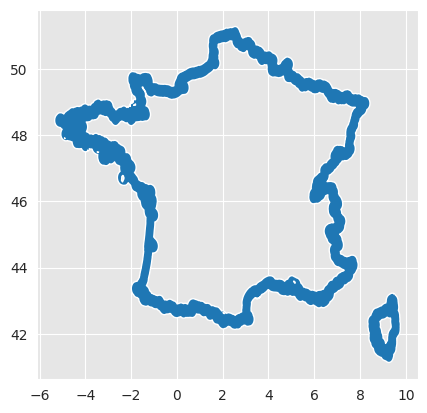

In [6]:
# border_zone = gdf_france.geometry.buffer(0.2)
border_zone = gdf_france.boundary
border_zone = gdf_france.boundary.buffer(0.2)
border_zone.plot()

In [17]:
import folium

# Discretisation de l'espace : 
# expe = "mistralai/Mistral-7B-Instruct-v0.3_float16_gps_fr"

# 2nd best models (instruct)
# expe = "mistralai/Mistral-Small-24B-Instruct-2501_float16_gps_fr"

expe = "mistralai/Mistral-Small-24B-Base-2501_float16_gps_fr"

# expe = "mistralai/Mistral-Nemo-Base-2407_float16_gps_fr"

# expe = "meta-llama/Llama-2-7b-chat-hf_int4_gps_en"

df_clean = gdf.dropna(subset=[
    f"{expe}_lat_predicted",
    f"{expe}_lon_predicted"
])


m = folium.Map(location=[46.6031, 1.8883], zoom_start=6)
for _, row in df_clean.iterrows():
    # Ajouter le point réel
    folium.CircleMarker(location=[row["Latitude"], row["Longitude"]],
                        color="blue", radius=4, fill=True, fill_color="blue", popup=row["city"]).add_to(m)
    
    # Ajouter le point prédit
    folium.CircleMarker(location=[row[f"{expe}_lat_predicted"], row[f"{expe}_lon_predicted"]],
                        color="red", radius=4, fill=True, fill_color="red", popup=row["city"]).add_to(m)

    # Ajouter une ligne entre les deux
    folium.PolyLine([(row["Latitude"], row["Longitude"]), 
                     (row[f"{expe}_lat_predicted"], row[f"{expe}_lon_predicted"])], 
                    color="green", weight=2, opacity=0.7).add_to(m)

m

KeyError: ['mistralai/Mistral-Small-24B-2501_float16_gps_fr_lat_predicted', 'mistralai/Mistral-Small-24B-2501_float16_gps_fr_lon_predicted']

In [8]:
m.save("./../../outputs/shifting_maps.html")

## Analyze Lon shiffted because of minus (-1)

In [9]:
lon_columns = [col for col in df.columns if col.endswith("_lon_predicted")]
lon_columns.append("Longitude")
negative_count = (df[lon_columns] < 0).sum().sort_values(ascending=False)
print(f"Number of real negative Lon: {negative_count['Longitude']}")
print("\n ----------------")
negative_count

Number of real negative Lon: 132

 ----------------


meta-llama/Llama-2-7b-chat-hf_int4_gps_en_lon_predicted                   251
mistralai/Mistral-Small-24B-Base-2501_float16_gps_en_lon_predicted        157
mistralai/Mistral-Small-24B-Base-2501_int8_gps_en_lon_predicted           154
mistralai/Mistral-Small-24B-Instruct-2501_float16_gps_fr_lon_predicted    141
mistralai/Mistral-Small-24B-Instruct-2501_float16_gps_en_lon_predicted    133
                                                                         ... 
Qwen/Qwen2.5-0.5B_int4_gps_fr_lon_predicted                                 0
Qwen/Qwen2.5-0.5B-Instruct_int8_gps_fr_lon_predicted                        0
Qwen/Qwen2.5-0.5B-Instruct_int4_gps_fr_lon_predicted                        0
Qwen/Qwen2.5-7B_float16_gps_en_lon_predicted                                0
mistralai/Mistral-7B-v0.1_float16_gps_fr_lon_predicted                      0
Length: 153, dtype: int64

In [10]:
expe = "mistralai/Mistral-7B-v0.1_float16_gps_fr"
expe = "mistralai/Mistral-Small-24B-Base-2501_float16_gps_fr"

df[df["Longitude"] <0][["Coordinates", f"{expe}_output", f"{expe}_lat_predicted", f"{expe}_lon_predicted"]].to_csv(f"./outputs/TMP/analyse_shift_lat_{expe.split('/')[-1]}.csv")

KeyError: "['mistralai/Mistral-Small-24B-Base-2501_float16_gps_fr_output'] not in index"